In [4]:
# !wget https://www.dropbox.com/s/2ksz7e8yc8sa9d6/test_7.zip?dl=0
# !wget https://s3-ap-southeast-1.amazonaws.com/iiiaider/train_7.zip
# !wget https://s3-ap-southeast-1.amazonaws.com/iiiaider/val_7.zip   

# !wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [1]:
# !rm -r test_7
# !unzip val_7.zip
# !unzip test_7.zip?dl=0
# !unzip train_7.zip

In [2]:
!ls -l
!pwd

total 8937068
-rw-r--r-- 1 root   root        16783 Jul 30 11:03 Keras_CFAR10_CNN.ipynb
-rw-r--r-- 1 root   root    662580712 Aug 16 12:18 VGG16_model_7_0816.h5
-rw-r--r-- 1 root   root      3093303 Aug 17 16:09 XRay_7diseases.ipynb
-rw-r--r-- 1 root   root    220900240 Aug 17 14:54 best_model_todate
drwxrwxrwt 3 root   root         4096 Jun  7 15:06 datasets
drwxr-xr-x 7 root   root         4096 Aug  3 15:14 face-recognition
-rw-r--r-- 1 root   root        90473 Aug  3 15:18 face_recognition.ipynb
drwxrwxrwx 2 daemon daemon       4096 Aug  2 12:15 jupyter
-rw-r--r-- 1 root   root         2672 Jul 27 11:55 nvidia-smi.ipynb
drwxr-xr-x 9 root   root         4096 Aug 14 17:41 test_7
-rw-r--r-- 1 root   root   1336391146 Aug 15 10:15 test_7.zip
-rw-r--r-- 1 root   root   1336391146 Aug 17 15:35 test_7.zip?dl=0
drwxr-xr-x 9 root   root         4096 Aug 14 16:56 train_7
-rw-r--r-- 1 root   root   4988101156 Aug 15 15:59 train_7.zip
drwxr-xr-x 9 root   root         4096 Aug 15 15:36 val_7
-rw

In [11]:
# !pip install imgaug
# !pip install mlxtend
# !pip install seaborn

In [2]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
from keras.preprocessing import image

color = sns.color_palette()
%matplotlib inline

Using TensorFlow backend.


In [3]:
# 設定tensorflow節點
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(111)
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0)
tf.set_random_seed(111)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
aug.seed(111)

In [4]:
# 訓練、測試、驗證資料的路徑

data_dir = Path('')
# data_dir = Path('content_dis3')
train_dir = data_dir / 'train_7'
test_dir = data_dir / 'test_7'
val_dir = data_dir / 'val_7'

### 訓練資料前處理

Emphysema：肺氣腫
Infiltration：肺浸潤
Mass：腫塊
Nodule：肺結節
noFind：健康
PNEUMONIA：肺炎
Pneumothorax：氣胸

In [5]:
# 取得路徑
emphysema_cases_dir = train_dir / 'Emphysema'
infiltration_cases_dir = train_dir / 'Infiltration'
mass_cases_dir = train_dir / 'Mass'
nodule_cases_dir = train_dir / 'Nodule'
noFind_cases_dir = train_dir / 'noFind'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'
pneumothorax_cases_dir = train_dir / 'Pneumothorax'

# 取得x-ray圖檔
emphysema_cases = emphysema_cases_dir.glob('*.png')
infiltration_cases = infiltration_cases_dir.glob('*.png')
mass_cases = mass_cases_dir.glob('*.png')
nodule_cases = nodule_cases_dir.glob('*.png')
noFind_cases = noFind_cases_dir.glob('*.png')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
pneumothorax_cases = pneumothorax_cases_dir.glob('*.png')


# 建立一個空list，把 path & image 放入
train_data = []

# Emphysema：肺氣腫
# Infiltration：肺浸潤
# Mass：腫塊
# Nodule：肺結節
# noFind：健康
# PNEUMONIA：肺炎
# Pneumothorax：氣胸

# Emphysema：肺氣腫 圖檔路徑 對應的label為 0
for img in emphysema_cases:
    train_data.append((img,0))

# Infiltration：肺浸潤 圖檔路徑 對應的label為 1
for img in infiltration_cases:
    train_data.append((img, 1))
        
# Mass：腫塊 圖檔路徑 對應的label為 2
for img in mass_cases:
    train_data.append((img, 2))

# Nodule：肺結節 圖檔路徑 對應的label為 3
for img in nodule_cases:
    train_data.append((img, 3))

# noFind：健康 圖檔路徑 對應的label為 4
for img in noFind_cases:
    train_data.append((img, 4))

# PNEUMONIA：肺炎 圖檔路徑 對應的label為 5
for img in pneumonia_cases:
    train_data.append((img, 5))

# Mass：腫塊 圖檔路徑 對應的label為 6
for img in pneumothorax_cases:
    train_data.append((img, 6))
    
# 將 train_data這個 list 拆成 'image' 及 'label' 並做成 dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# 隨機取得含有label=0|label=1|label=2的數據
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# 看前五筆資料
train_data.head()


,image,label
0,train_7/noFind/00001621_000.png,4
1,train_7/Pneumothorax/00018921_061.png,6
2,train_7/Nodule/00025806_003.png,3
3,train_7/noFind/00001255_035.png,4
4,train_7/Pneumothorax/00029950_003.png,6


5    3485
1    2946
4    2939
3    1949
6    1581
2    1540
0     643
Name: label, dtype: int64


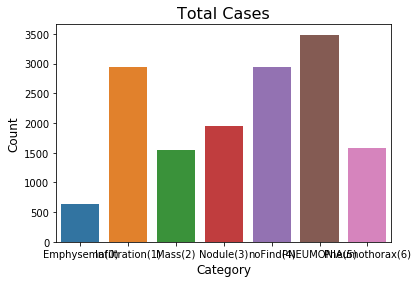

In [6]:
# 計算label數量 +繪圖
# Emphysema：肺氣腫 Infiltration：肺浸潤 Mass：腫塊 Nodule：肺結節 noFind：健康 PNEUMONIA：肺炎 Pneumothorax：氣胸
cases_count = train_data['label'].value_counts()
print(cases_count)

import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(cases_count.index,cases_count.values) 
plt.title("Total Cases", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Emphysema(0)', 'Infiltration(1)', 'Mass(2)', 'Nodule(3)', 'noFind(4)', 'PNEUMONIA(5)', 'Pneumothorax(6)'])
plt.show()

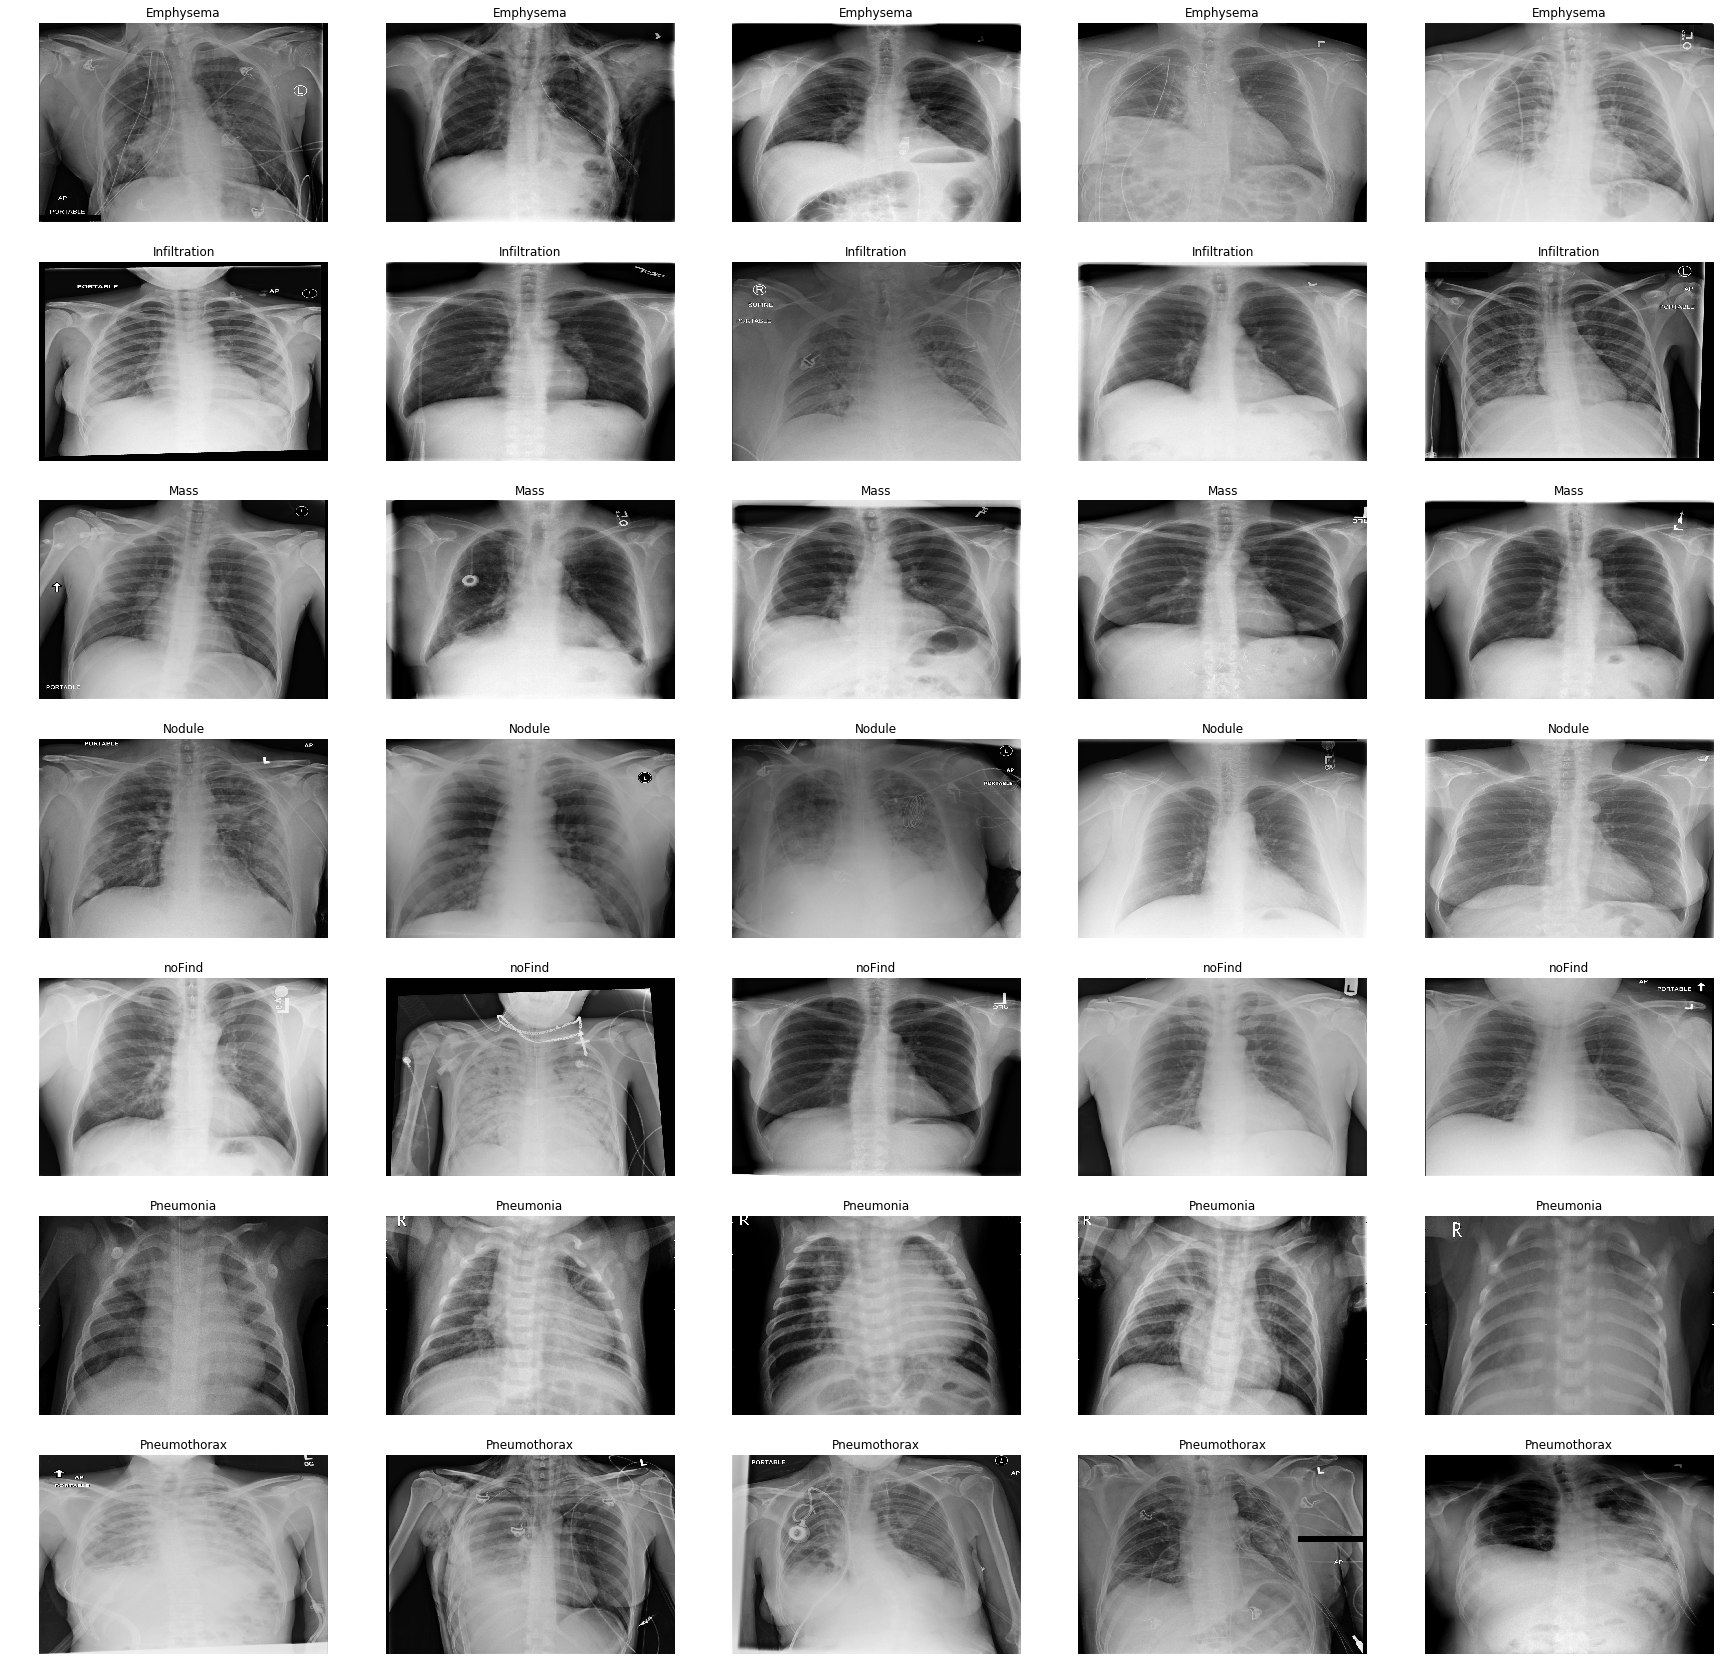

In [7]:
# Emphysema：肺氣腫 Infiltration：肺浸潤 Mass：腫塊 Nodule：肺結節 noFind：健康 PNEUMONIA：肺炎 Pneumothorax：氣胸
# 隨機取三類別五張圖片
emphysema_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
infiltration_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
mass_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()
nodule_samples = (train_data[train_data['label']==3]['image'].iloc[:5]).tolist()
noFind_samples = (train_data[train_data['label']==4]['image'].iloc[:5]).tolist()
pneumonia_samples = (train_data[train_data['label']==5]['image'].iloc[:5]).tolist()
pneumothorax_samples = (train_data[train_data['label']==6]['image'].iloc[:5]).tolist()

# 繪圖
samples = emphysema_samples + infiltration_samples + mass_samples + nodule_samples + noFind_samples + pneumonia_samples + pneumothorax_samples
del emphysema_samples, infiltration_samples, mass_samples, nodule_samples, noFind_samples, pneumonia_samples, pneumothorax_samples

f, ax = plt.subplots(7,5, figsize=(30,30))
for i in range(35):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Emphysema")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Infiltration")
    elif i>=10 and i<15:
        ax[i//5, i%5].set_title("Mass")
    elif i>=15 and i<20:
        ax[i//5, i%5].set_title("Nodule")
    elif i>=20 and i<25:
        ax[i//5, i%5].set_title("noFind")
    elif i>=25 and i<30:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Pneumothorax")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### 驗證資料前處理
val_dir

In [8]:
emphysema_cases_dir = val_dir / 'Emphysema'
infiltration_cases_dir = val_dir / 'Infiltration'
mass_cases_dir = val_dir / 'Mass'
nodule_cases_dir = val_dir / 'Nodule'
noFind_cases_dir = val_dir / 'noFind'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'
pneumothorax_cases_dir = val_dir / 'Pneumothorax'

# 取得x-ray圖檔
emphysema_cases = emphysema_cases_dir.glob('*.png')
infiltration_cases = infiltration_cases_dir.glob('*.png')
mass_cases = mass_cases_dir.glob('*.png')
nodule_cases = nodule_cases_dir.glob('*.png')
noFind_cases = noFind_cases_dir.glob('*.png')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
pneumothorax_cases = pneumothorax_cases_dir.glob('*.png')

# 建立兩個空list，把 image & label 放入
valid_data = []
valid_labels = []

# 將輸入圖像皆轉為RGB、圖像大小調整為224x224

# emphysema 0
for img in emphysema_cases:
    #取得圖檔
    img = cv2.imread(str(img))
    #調整大小
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    #轉為RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #縮放圖檔於 0~1
    img = img.astype(np.float32)/255.
    #指定為兩類中的第一類
    label = to_categorical(0, num_classes=7)
    #放入valid_data的list中
    valid_data.append(img)
    #放入valid_labels的list中
    valid_labels.append(label)
    
# infiltration 1       
for img in infiltration_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=7)
    valid_data.append(img)
    valid_labels.append(label)

# mass 2    
for img in mass_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=7)
    valid_data.append(img)
    valid_labels.append(label)

# nodule 3   
for img in nodule_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(3, num_classes=7)
    valid_data.append(img)
    valid_labels.append(label)
    
# noFind 4
for img in noFind_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(4, num_classes=7)
    valid_data.append(img)
    valid_labels.append(label)

# infiltration 5       
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(5, num_classes=7)
    valid_data.append(img)
    valid_labels.append(label)
    
# pneumothorax 6       
for img in pneumothorax_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(6, num_classes=7)
    valid_data.append(img)
    valid_labels.append(label)

# 將img及label轉換為nupy
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
# print(valid_data)
# print(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)


Total number of validation examples:  (1679, 224, 224, 3)
Total number of labels: (1679, 7)


### 建模前處理



In [9]:
#使用iaa.OneOf()，在每次迭代中，採用1~N種增強技術並將其應用於樣本
seq = iaa.SomeOf((1, None), [
    iaa.Fliplr(0.5), #水平翻轉0~1
    iaa.Flipud(0.2), #垂直翻轉0~1, 1為完全顛倒
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # 削尖
    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # 浮雕
    iaa.Affine(rotate=20), #迴轉
    iaa.Multiply((1.2, 1.5)), #隨機亮度
    iaa.GaussianBlur(sigma=(0, 3.0)), # 模糊化1~9
    iaa.Multiply((0.5, 1.5), per_channel=0.5),
    iaa.FrequencyNoiseAlpha(
                exponent=(-4, 0),
                first=iaa.Multiply((0.5, 1.5), per_channel=True),
                second=iaa.ContrastNormalization((0.5, 2.0))),
    iaa.Dropout((0.01, 0.1), per_channel=0.5),
    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2)
])

數據生成器_data_gen()
TODO: batch_data[count+1]

   batch_labels[count+1] 中調成 +2、+3

In [10]:
def data_gen(data, batch_size):
    # 計算圖像長度
    n = len(data)
    # 長度/每批訓練量
    steps = n//batch_size
       
    #定義batch_data及batch_labels的numpy　array 
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,7), dtype=np.float32)
    
    # 以索引取得輸入資料的numpy array
    indices = np.arange(n)
        
    # 圖形前處理
    i =0
    while True:
        np.random.shuffle(indices)
        # 取得下一個訓練批量 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot (0,1的值)
            encoded_label = to_categorical(label, num_classes=7)
            # 調整圖形大小
            img = cv2.imread(str(img_name))
            if img is not None:
                img = cv2.resize(img, (224,224))
            else:
                continue
            
            # 確認是否為灰階
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # 預設讀取RGB
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            #　縮放圖檔於 0~1
            orig_img = img.astype(np.float32)/255.

           
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # 重要的一步：擴增數據較少的數據
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
                
                
            elif label==2 and count < batch_size-2:
                aug_img3 = seq.augment_image(img)
                aug_img4 = seq.augment_image(img)
                aug_img3 = cv2.cvtColor(aug_img3, cv2.COLOR_BGR2RGB)
                aug_img4 = cv2.cvtColor(aug_img4, cv2.COLOR_BGR2RGB)
                aug_img3 = aug_img3.astype(np.float32)/255.
                aug_img4 = aug_img4.astype(np.float32)/255.

                batch_data[count+1] = aug_img3
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img4
                batch_labels[count+2] = encoded_label
                count +=2
            
            elif label==6 and count < batch_size-2:
                aug_img3 = seq.augment_image(img)
                aug_img4 = seq.augment_image(img)
                aug_img3 = cv2.cvtColor(aug_img3, cv2.COLOR_BGR2RGB)
                aug_img4 = cv2.cvtColor(aug_img4, cv2.COLOR_BGR2RGB)
                aug_img3 = aug_img3.astype(np.float32)/255.
                aug_img4 = aug_img4.astype(np.float32)/255.

                batch_data[count+1] = aug_img3
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img4
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break

        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

### 模型生成器_build_model()

進行部分遷移學習、導入權重其餘的模型將從頭開始訓練。

TODO:可以嘗試dropout少一點、換上課老師的模型

In [11]:
def build_model(): 
    # model.layers[0] 
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv5_1')(x)
    x = BatchNormalization(name='bn5')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv5_2')(x)
    x = BatchNormalization(name='bn6')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv5_3')(x)
    x = MaxPooling2D((2,2), name='pool5')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(2048, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(1024, activation='relu', name='fc2')(x)
    x = Dropout(0.25, name='dropout2')(x)
    x = Dense(7, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [12]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

### 套用權重

In [13]:
f = h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')
# f = h5py.File('content_dis3/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')


w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

w,b = f['block3_conv1']['block3_conv1_W_1:0'], f['block3_conv1']['block3_conv1_b_1:0']
model.layers[7].set_weights = [w,b]

w,b = f['block3_conv2']['block3_conv2_W_1:0'], f['block3_conv2']['block3_conv2_b_1:0']
model.layers[9].set_weights = [w,b]

w,b = f['block3_conv3']['block3_conv3_W_1:0'], f['block3_conv3']['block3_conv3_b_1:0']
model.layers[11].set_weights = [w,b]

w,b = f['block4_conv1']['block4_conv1_W_1:0'], f['block4_conv1']['bloc4_conv1_b_1:0']
model.layers[13].set_weights = [w,b]

w,b = f['block4_conv2']['block4_conv2_W_1:0'], f['block4_conv2']['bloc4_conv2_b_1:0']
model.layers[15].set_weights = [w,b]

w,b = f['block4_conv3']['block4_conv3_W_1:0'], f['block4_conv3']['bloc4_conv3_b_1:0']
model.layers[17].set_weights = [w,b]

f.close()
model.summary()   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [14]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)


## 訓練
### 訓練時間很長 model請先調整好再訓練

大概第二輪也0.5~0.6左右就不用試了

TODO:nb_epochs > 10 , 注意colab一段時間會中斷連線

In [15]:
batch_size = 12
nb_epochs = 10

# 呼叫圖形增強器(訓練資料)
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# 設定訓練步數
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 1256 and 1679


In [16]:
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1, 1:0.3, 2:0.7, 3:0.7, 4:0.4, 5:0.25, 6:0.6})

Epoch 1/10
1256/1256 [==============================] - 237s 189ms/step - loss: 0.1915 - acc: 0.8624 - val_loss: 0.4761 - val_acc: 0.8599
Epoch 2/10
1256/1256 [==============================] - 223s 177ms/step - loss: 0.1712 - acc: 0.8788 - val_loss: 0.6957 - val_acc: 0.8571
Epoch 3/10
1256/1256 [==============================] - 223s 178ms/step - loss: 0.1675 - acc: 0.8799 - val_loss: 0.6726 - val_acc: 0.8569
Epoch 4/10
1256/1256 [==============================] - 220s 175ms/step - loss: 0.1675 - acc: 0.8801 - val_loss: 0.4326 - val_acc: 0.8766
Epoch 5/10
1256/1256 [==============================] - 223s 178ms/step - loss: 0.1633 - acc: 0.8817 - val_loss: 0.5694 - val_acc: 0.8578
Epoch 6/10
1256/1256 [==============================] - 219s 174ms/step - loss: 0.1651 - acc: 0.8814 - val_loss: 0.2999 - val_acc: 0.8895
Epoch 7/10
1256/1256 [==============================] - 220s 175ms/step - loss: 0.1613 - acc: 0.8810 - val_loss: 0.3495 - val_acc: 0.8859
Epoch 8/10
1256/1256 [============

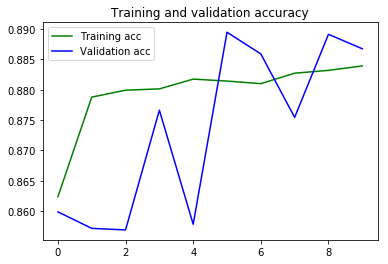

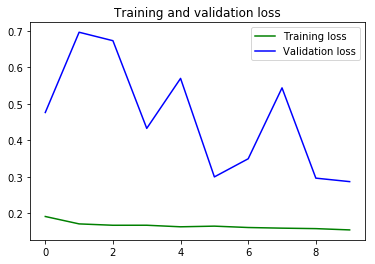

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### test 

In [19]:
emphysema_cases_dir = test_dir / 'Emphysema'
infiltration_cases_dir = test_dir / 'Infiltration'
mass_cases_dir = test_dir / 'Mass'
nodule_cases_dir = test_dir / 'Nodule'
noFind_cases_dir = test_dir / 'noFind'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'
pneumothorax_cases_dir = test_dir / 'Pneumothorax'

# 取得x-ray圖檔
emphysema_cases = emphysema_cases_dir.glob('*.png')
infiltration_cases = infiltration_cases_dir.glob('*.png')
mass_cases = mass_cases_dir.glob('*.png')
nodule_cases = nodule_cases_dir.glob('*.png')
noFind_cases = noFind_cases_dir.glob('*.png')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
pneumothorax_cases = pneumothorax_cases_dir.glob('*.png')

# 建立兩個空list，把 image & label 放入
test_data = []
test_labels = []

# 將輸入圖像皆轉為RGB、圖像大小調整為224x224

# emphysema 0
for img in emphysema_cases:
    #取得圖檔
    img = cv2.imread(str(img))
    #調整大小
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    #轉為RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #縮放圖檔於 0~1
    img = img.astype(np.float32)/255.
    #指定為兩類中的第一類
    label = to_categorical(0, num_classes=7)
    #放入valid_data的list中
    test_data.append(img)
    #放入valid_labels的list中
    test_labels.append(label)
    
# infiltration 1       
for img in infiltration_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=7)
    test_data.append(img)
    test_labels.append(label)

# mass 2    
for img in mass_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=7)
    test_data.append(img)
    test_labels.append(label)

# nodule 3   
for img in nodule_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(3, num_classes=7)
    test_data.append(img)
    test_labels.append(label)
    
# noFind 4
for img in noFind_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(4, num_classes=7)
    test_data.append(img)
    test_labels.append(label)

# infiltration 5       
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(5, num_classes=7)
    test_data.append(img)
    test_labels.append(label)
    
# pneumothorax 6       
for img in pneumothorax_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(6, num_classes=7)
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (3610, 224, 224, 3)
Total number of labels: (3610, 7)


In [20]:
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

3610/3610 [==============================] - 12s 3ms/step
Loss on test set:  0.3263582304120064
Accuracy on test set:  0.8722991784193509


### 儲存

In [21]:
# 儲存完整模型
model.save('VGG16_model_7_0821.h5')  

### 觀察測試結果

In [22]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Get predictions
preds = model.predict(test_data, batch_size=32)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(3610,)
(3610,)


In [67]:
# Emphysema：肺氣腫 Infiltration：肺浸潤 Mass：腫塊 Nodule：肺結節 noFind：健康 Pneumonia：肺炎 Pneumothorax：氣胸
# Get the confusion matrix
# cm  = confusion_matrix(orig_test_labels, preds)
# plt.figure()
# plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
# plt.xticks(range(7), ['Emphysema', 'Infiltration', 'Mass', 'Nodule', 'noFind', 'Pneumonia', 'Pneumothorax'], fontsize=16)
# plt.yticks(range(7), ['Emphysema', 'Infiltration', 'Mass', 'Nodule', 'noFind', 'Pneumonia', 'Pneumothorax'], fontsize=16)
# plt.show()

### 預測模組

In [ ]:
def x_ray_check(case):
    case_data = []
    case = cv2.imread(str(case))
    case = cv2.resize(case, (224,224))

    if case.shape[2] ==1:
        case = np.dstack([case, case, case])
    else:
        case = cv2.cvtColor(case, cv2.COLOR_BGR2RGB)

    case = case.astype(np.float32)/255.
    case_data.append(case)

    case_data = np.array(case_data)



    return case_data

##### pic = 'test_7/Emphysema/00000013_042.png'
##### pic2 = 'test_7/Infiltration/00018187_044.png'
##### pic3 = 'test_7/Mass/00009349_039.png'
##### pic4 = 'test_7/Nodule/00000105_004.png'
##### pic5 = 'test_7/noFind/00000011_001.png'
##### pic6 = 'test_7/PNEUMONIA/person100_bacteria_475.jpeg'
##### pic7 = 'test_7/Pneumothorax/00003072_022.png'

<PIL.Image.Image image mode=RGB size=400x400 at 0x7FC724694898>
[[0.19284135 0.10577156 0.23381847 0.20851193 0.11193194 0.01679176
  0.13033289]]
The percentage is: 23.38 %
The prediction is: Mass <腫塊>
[[0.12855607 0.13754223 0.16197886 0.2911717  0.1388869  0.00144409
  0.14042006]]
The percentage is: 29.12 %
The prediction is: Nodule <肺結節>
[[0.19345699 0.06925032 0.33128455 0.13941218 0.06189821 0.00169076
  0.20300695]]
The percentage is: 33.13 %
The prediction is: Mass <腫塊>
[[0.0806228  0.16554104 0.18726939 0.28622386 0.18024214 0.00140053
  0.09870026]]
The percentage is: 28.62 %
The prediction is: Nodule <肺結節>
[[0.07391544 0.15465723 0.16693868 0.28483355 0.13510387 0.00140525
  0.18314599]]
The percentage is: 28.48 %
The prediction is: Nodule <肺結節>
[[9.7219873e-04 7.8111020e-04 3.1449544e-04 2.5300830e-04 2.7728069e-04
  9.9678266e-01 6.1921071e-04]]
The percentage is: 99.68 %
The prediction is: Pneumonia <肺炎>
[[8.11443403e-02 9.35049132e-02 1.38754711e-01 1.97218344e-01
  1.1

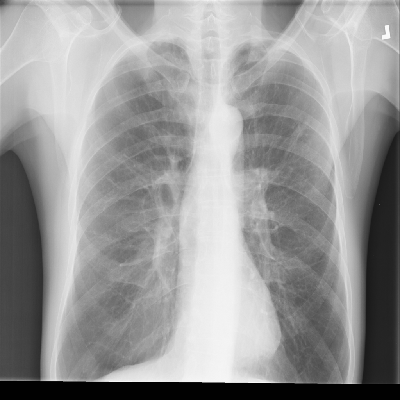

In [26]:
# Emphysema：肺氣腫 Infiltration：肺浸潤 Mass：腫塊 Nodule：肺結節 noFind：健康 Pneumonia：肺炎 Pneumothorax：氣胸

# pic = 'test_7/noFind/00000014_000.png'
# pic = 'test_7/Pneumothorax/00000246_008.png'


# pic = 'test_7/Emphysema/00000013_042.png'
# pic2 = 'test_7/Infiltration/00018187_044.png'
# pic3 = 'test_7/Mass/00009349_039.png'
# pic4 = 'test_7/Nodule/00000105_004.png'
# pic5 = 'test_7/noFind/00000011_001.png'
# pic6 = 'test_7/PNEUMONIA/person100_bacteria_475.jpeg'
# pic7 = 'test_7/Pneumothorax/00003072_022.png'


pic = 'test_7/Emphysema/00016434_003.png'
pic2 = 'test_7/Infiltration/00030652_001.png'
pic3 = 'test_7/Mass/00018101_007.png'
pic4 = 'test_7/Nodule/00000573_012.png'
pic5 = 'test_7/noFind/00000963_002.png'
pic6 = 'test_7/PNEUMONIA/person100_bacteria_475.jpeg'
pic7 = 'test_7/Pneumothorax/00003072_022.png'

img_path = pic
img = image.load_img(img_path, target_size=(400, 400))

img_path2 = pic2
img2 = image.load_img(img_path, target_size=(400, 400))

img_path3 = pic3
img3 = image.load_img(img_path, target_size=(400, 400))

img_path4 = pic4
img4 = image.load_img(img_path, target_size=(400, 400))

img_path5 = pic5
img5 = image.load_img(img_path, target_size=(400, 400))

img_path6 = pic6
img6 = image.load_img(img_path, target_size=(400, 400))

img_path7 = pic7
img7 = image.load_img(img_path, target_size=(400, 400))

print(img)
print("="*90)

def x_ray_check(case):
    case_data = []
    case = cv2.imread(str(case))
    case = cv2.resize(case, (224,224))

    if case.shape[2] ==1:
        case = np.dstack([case, case, case])
    else:
        case = cv2.cvtColor(case, cv2.COLOR_BGR2RGB)

    case = case.astype(np.float32)/255.
    case_data.append(case)

    case_data = np.array(case_data)

    preds = model.predict(case_data, batch_size=16)
    print(preds)

    predic = np.argmax(preds, axis=1)
    if predic == 0:
        result = 'The prediction is: Emphysema <肺氣腫>'
        print("The percentage is:",str(round(preds[0][0]*100,2)),"%")
        print(result)
    elif predic == 1:
        result = 'The prediction is: Infiltration <肺浸潤>'
        print("The percentage is:",str(round(preds[0][1]*100,2)),"%")
        print(result)
    elif predic == 2:
        result = 'The prediction is: Mass <腫塊>'
        print("The percentage is:",str(round(preds[0][2]*100,2)),"%")
        print(result)
    elif predic == 3:
        result = 'The prediction is: Nodule <肺結節>'
        print("The percentage is:",str(round(preds[0][3]*100,2)),"%")
        print(result)
    elif predic == 4:
        result = 'The prediction is: noFind <健康>'
        print("The percentage is:",str(round(preds[0][4]*100,2)),"%")
        print(result)
    elif predic == 5:
        result = 'The prediction is: Pneumonia <肺炎>'
        print("The percentage is:",str(round(preds[0][5]*100,2)),"%")
        print(result)
    else:
        result = 'The prediction is: Pneumothorax <氣胸>'
        print("The percentage is:",str(round(preds[0][6]*100,2)),"%")
        print(result)
        
x_ray_check(img_path)
img
x_ray_check(img_path2)
img2
x_ray_check(img_path3)
img3
x_ray_check(img_path4)
img4
x_ray_check(img_path5)
img5
x_ray_check(img_path6)
img6
x_ray_check(img_path7)
img7

### 進行預測

In [117]:
prediction = model.predict_on_batch(test_data)

ResourceExhaustedError: OOM when allocating tensor with shape[3610,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv1_1_2/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Conv1_1_2/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, Conv1_1_2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: fc3_2/Softmax/_3729 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_524_fc3_2/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [118]:
predicted_probability = model.predict(test_data)

In [ ]:
def 